## Wrinkles Filter

In [27]:
import cv2,sys,dlib,time,math
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [28]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

In [29]:
def alphaBlend(alpha, foreground, background):
  fore = np.zeros(foreground.shape, dtype=foreground.dtype)
  fore = cv2.multiply(alpha, foreground, fore, 1/255.0)

  alphaPrime = np.ones(alpha.shape, dtype=alpha.dtype)*255 - alpha
  back = np.zeros(background.shape, dtype=background.dtype)
  back = cv2.multiply(alphaPrime, background, back, 1/255.0)

  outImage = cv2.add(fore, back)
  return outImage


# Desaturate image
def desaturateImage(im, scaleBy):

  # Convert input image to HSV
  imgHSV = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

  # Multiple saturation by the scale
  imgHSV[:, :, 1] = imgHSV[:, :, 1]*scaleBy

  # Convert HSV to RGB
  outImage = cv2.cvtColor(imgHSV, cv2.COLOR_HSV2BGR)

  return outImage

def removePolygonFromMask(mask, points, pointsIndex):
  hullPoints = []
  for pIndex in pointsIndex:
    hullPoints.append(points[pIndex])

  cv2.fillConvexPoly(mask, np.int32(hullPoints), (0, 0, 0))


def appendForeheadPoints(points):
  offsetScalp = 3.0
  brows = [25, 23, 20, 18]
  browsReference = [45, 47, 40, 36]

  for browPoint, browRefPoint in zip(brows, browsReference):
    foreheadPointX = int(offsetScalp * (points[browPoint][0] - points[browRefPoint][0]) + points[browRefPoint][0])
    foreheadPointY = int(offsetScalp * (points[browPoint][1] - points[browRefPoint][1]) + points[browRefPoint][1])
    points.append((foreheadPointX, foreheadPointY))

def getFaceMask(size, points):
  # Left eye polygon
  leftEye = [36, 37, 38, 39, 40, 41]
  # Right eye polygon
  rightEye = [42, 43, 44, 45, 46, 47]
  # Mouth polygon
  mouth = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
  # Nose polygon
  nose = [28, 31, 33, 35]

  # Find Convex hull of all points
  hullIndex = cv2.convexHull(np.array(points), returnPoints=False)
  
  # Convert hull index to list of points
  hullInt = []
  for hIndex in hullIndex:
    hullInt.append(points[hIndex[0]])

  # Create mask such that convex hull is white
  mask = np.zeros((size[0], size[1], 3), dtype=np.uint8)
  cv2.fillConvexPoly(mask, np.int32(hullInt), (255, 255, 255))

  # Remove eyes, mouth and nose from the mask
  removePolygonFromMask(mask, points, leftEye)
  removePolygonFromMask(mask, points, rightEye)
  removePolygonFromMask(mask, points, nose)
  removePolygonFromMask(mask, points, mouth)

  return mask



In [30]:
modelPath = DATA_PATH + "models/shape_predictor_68_face_landmarks.dat"

# initialize face detector
faceDetector = dlib.get_frontal_face_detector()
# initialize facial landmark detector
landmarkDetector = dlib.shape_predictor(modelPath)

In [31]:
# File to copy wrinkles from
filename1 = DATA_PATH + "images/wrinkle2.jpg"

# File to apply aging
filename2 = DATA_PATH + "images/ted_cruz.jpg"

t = time.time()

# Read images
img1 = cv2.imread(filename1)
img2 = cv2.imread(filename2)

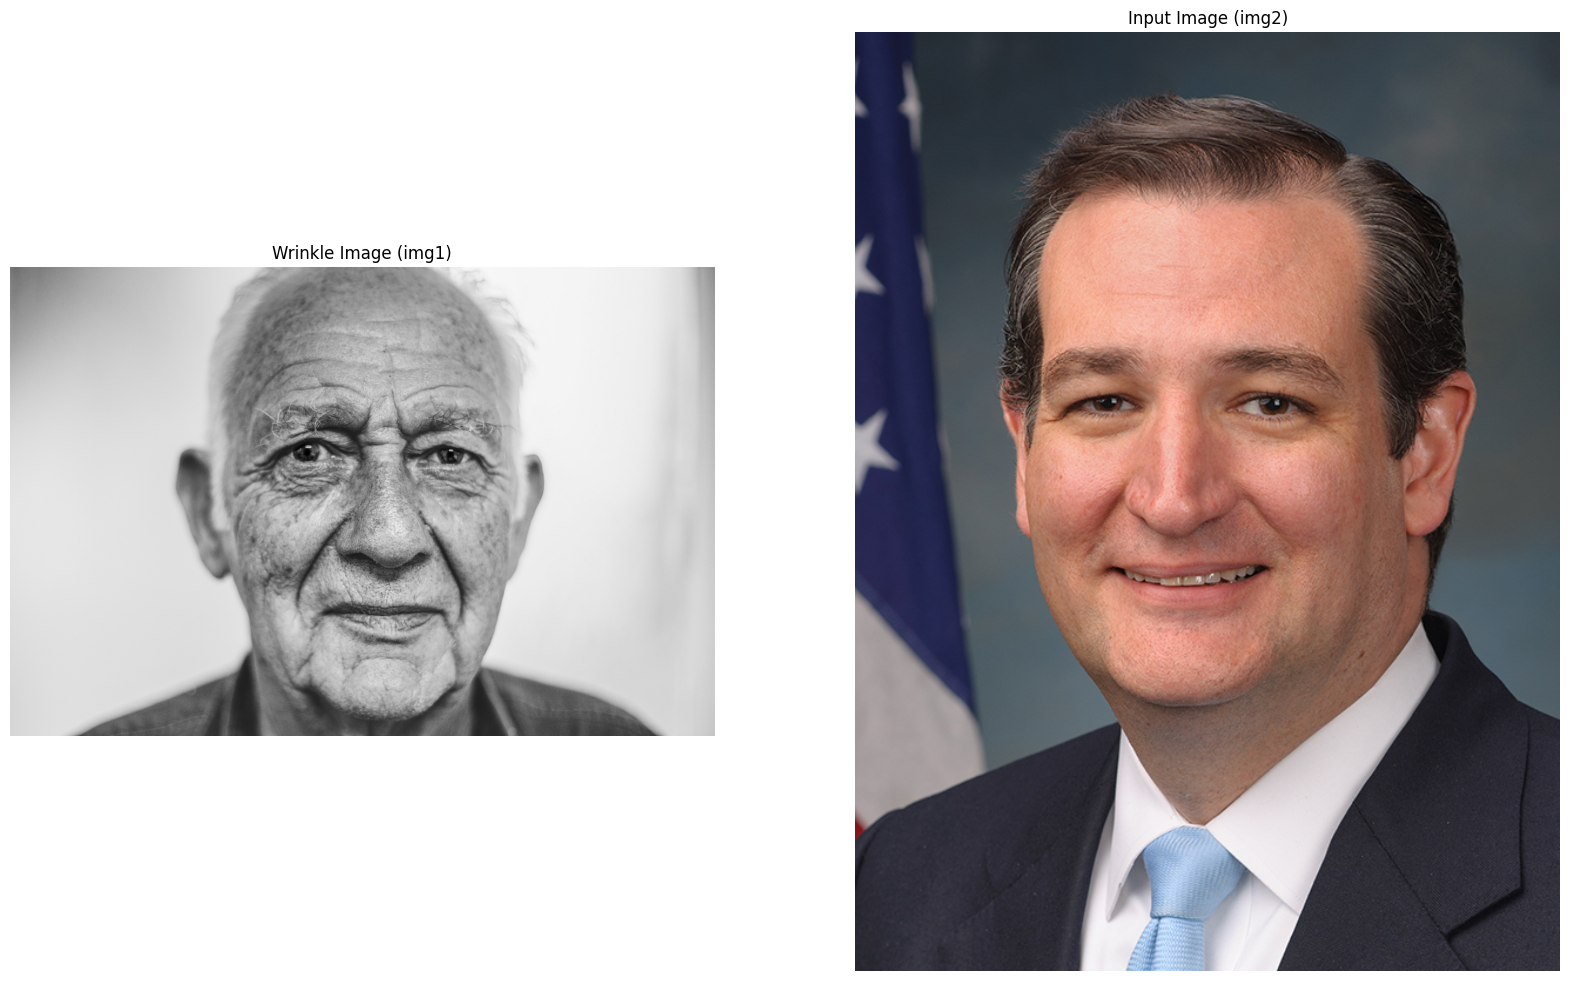

In [32]:
plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(img1[:,:,::-1])
plt.title("Wrinkle Image (img1)")
ax = plt.axis('off')

plt.subplot(122)
plt.imshow(img2[:,:,::-1])
plt.title("Input Image (img2)")
ax = plt.axis('off')

plt.show()

In [33]:
# Find landmarks
points1 = fbc.getLandmarks(faceDetector, landmarkDetector, img1)
points2 = fbc.getLandmarks(faceDetector, landmarkDetector, img2)

# Find forehead points
appendForeheadPoints(points1)
appendForeheadPoints(points2)

In [34]:
# Find Delaunay Triangulation
sizeImg1 = img1.shape
rect = (0, 0, sizeImg1[1], sizeImg1[0])
dt = fbc.calculateDelaunayTriangles(rect, points1)

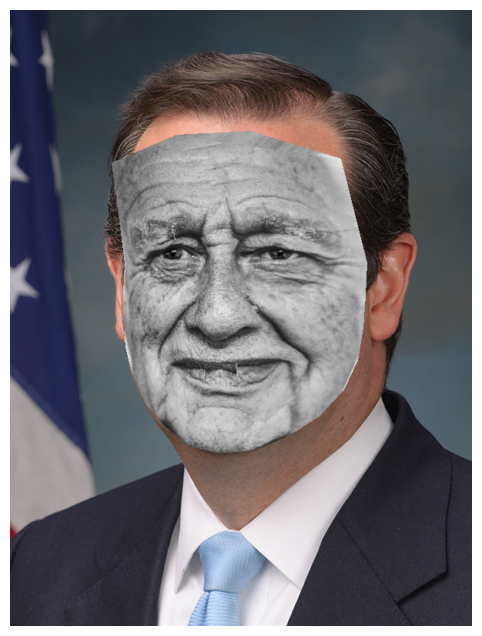

In [35]:
# Convert image for warping
img1 = np.float32(img1)/255.0
img2 = np.float32(img2)/255.0

# Warp wrinkle image to face image
img1Warped = np.copy(img2)
img1Warped = fbc.warpImage(img1, img1Warped, points1, points2, dt, useOutputImageSize=True)
img1Warped = np.uint8(img1Warped*255.0)
img2 = np.uint8(img2*255.0)

plt.imshow(img1Warped[:,:,::-1])
ax = plt.axis('off')
plt.show()

In [36]:
# Calculate face mask for seamless cloning
mask = getFaceMask(img2.shape[0:2], points2)

# Seamlessly clone the wrinkle image onto original face
r1 = cv2.boundingRect(np.float32(points2))
# Bounding rectangle r1 has 4 elements: left(x1), top(y1), 
# width(w), height(h)
center1X = r1[0] + int(r1[2]/2.0)
center1Y = r1[1] + int(r1[3]/2.0)
center1 = (center1X, center1Y)
clonedOutput = cv2.seamlessClone(img1Warped, img2, 
                               mask, center1, 
                               cv2.MIXED_CLONE)

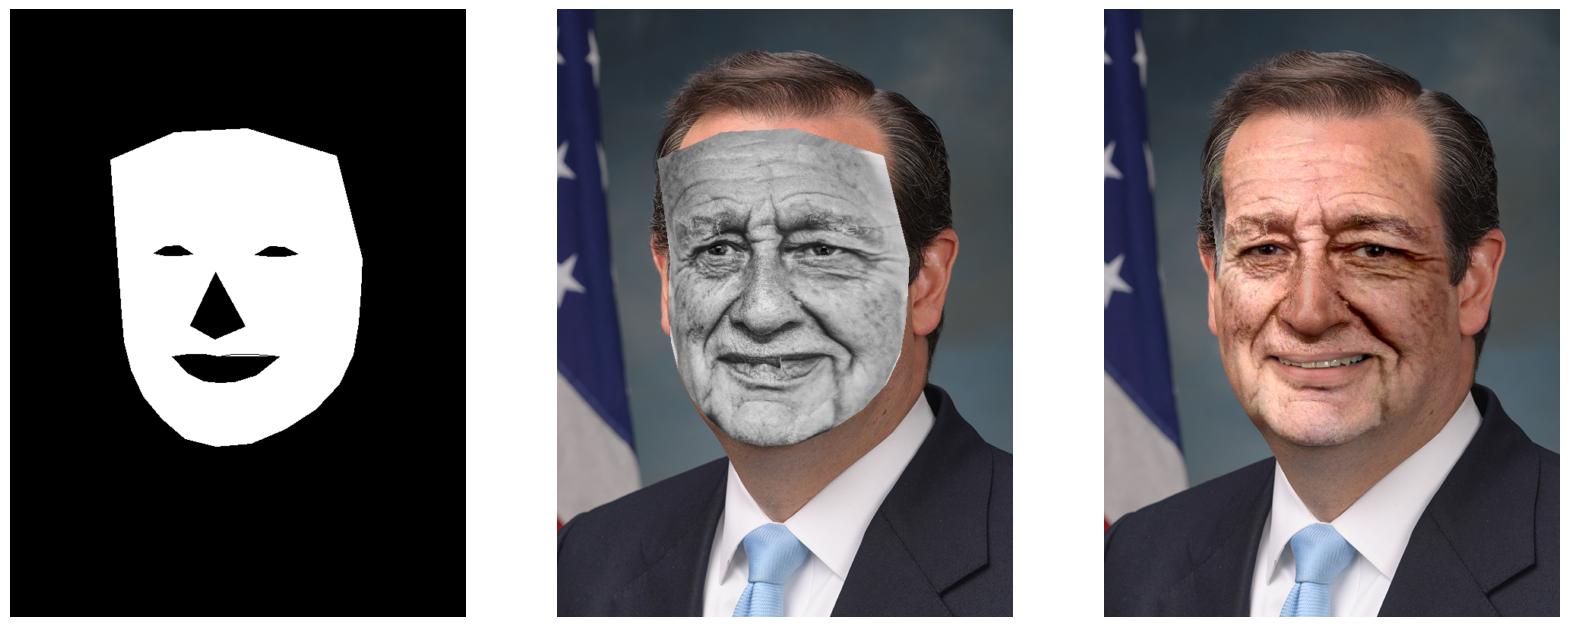

In [37]:
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(mask)
ax = plt.axis('off')


plt.subplot(132)
plt.imshow(img1Warped[:,:,::-1])
ax = plt.axis('off')


plt.subplot(133)
plt.imshow(clonedOutput[:,:,::-1])
ax = plt.axis('off')


plt.show()

In [38]:
# Blurring face mask to alpha blend to hide seams
maskHeight, maskWidth = mask.shape[0:2]
maskSmall = cv2.resize(mask, (256, int(maskHeight*256.0/maskWidth)))
maskSmall = cv2.erode(maskSmall, (-1, -1), 25)
maskSmall = cv2.GaussianBlur(maskSmall, (51, 51), 0, 0)
mask = cv2.resize(maskSmall, (maskWidth, maskHeight))

In [39]:
agedImage = alphaBlend(mask, clonedOutput, img2)

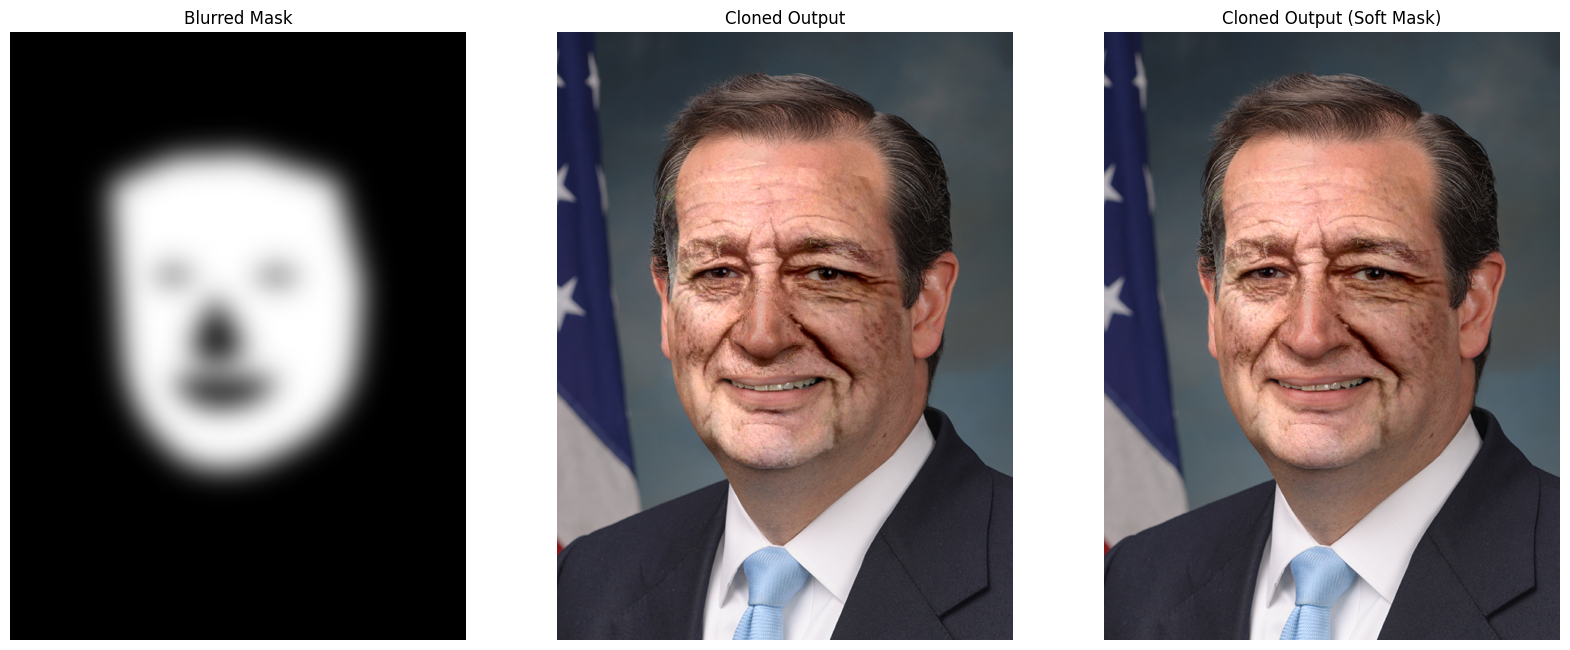

In [40]:
plt.figure(figsize=(20,20))

plt.subplot(131)
plt.imshow(mask)
plt.title("Blurred Mask")
ax = plt.axis('off')

plt.subplot(132)
plt.imshow(clonedOutput[:,:,::-1])
plt.title("Cloned Output")
ax = plt.axis('off')

plt.subplot(133)
plt.imshow(agedImage[:,:,::-1])
plt.title("Cloned Output (Soft Mask)")
ax = plt.axis('off')

plt.show()

In [43]:
""" 
Wrinkles

1. Create extra points like forehead points and attach reference points for stretching
2. Get Landmarks points for both image
3. Append forhead points
4. Calculate delaunay Trianlges of points1
5. Apply warp triangle using dt
6. Create face mask of points2 and 
    6.1 create convex hull
    6.2 create mask using convex hull index
    6.3 remove nose, mouth and eye  (replace with black color)
7. Apply seamless cloning
8. Apply blur on forehead to match
"""

' \nWrinkles\n\n1. Create extra points like forehead points and attach reference points for stretching\n2. Get Landmarks points for both image\n3. Append forhead points\n4. Calculate delaunay Trianlges of points1\n5. Apply warp triangle using dt\n6. Create face mask of points2 and \n    6.1 create convex hull\n    6.2 create mask using convex hull index\n    6.3 remove nose, mouth and eye  (replace with black color)\n7. Apply seamless cloning\n8. Apply blur on forehead to match\n'